#### Importing Relevant Libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from typing import Dict, List, Tuple, Any

# For display
pd.set_option('display.max_columns', None)


import os
from sqlalchemy import create_engine
from dotenv import load_dotenv

#### Read Data From PostgreSQL

In [2]:
# Load credentials from .env file
load_dotenv()

def get_db_engine():
    db_url = (
        f"postgresql://{os.getenv('DB_USER')}:{os.getenv('DB_PASSWORD')}@"
        f"{os.getenv('DB_HOST')}:{os.getenv('DB_PORT')}/{os.getenv('DB_NAME')}"
    )
    return create_engine(db_url)


engine = get_db_engine()

# Queries to read all tables into DataFrames
tables = {
    "fact_transactions":None,
    "fact_predictions":None, 
    "fact_applications":None,
    "dim_bureau":None,
    "dim_customer_profiles":None
}

for table in tables:
    tables[table] = pd.read_sql(f"SELECT * FROM {table}", engine)
    print(f"Loaded {table} ({tables[table].shape[0]} rows)")

# Access DataFrames
transactions_df = tables["fact_transactions"]
predictions_df = tables["fact_predictions"]
applications_df = tables["fact_applications"]
bureau_df = tables["dim_bureau"]
customer_profiles_df = tables["dim_customer_profiles"]

Loaded fact_transactions (100000 rows)
Loaded fact_predictions (50000 rows)
Loaded fact_applications (100000 rows)
Loaded dim_bureau (25000 rows)
Loaded dim_customer_profiles (25000 rows)


#### Data Exploration

###### Transaction Data

In [4]:
transactions_df.head()

,transaction_id,customer_id,transaction_date,amount,merchant_category,transaction_type,location,device_info,fraud_flag,investigation_status,created_at
0,TXN_00000001,CUST_004019,2024-03-25 11:24:31,34.85,Groceries,Purchase,Manchester,Mobile,0,Not Investigated,2025-08-16 22:11:04.525090
1,TXN_00000002,CUST_000222,2022-05-24 14:21:01,84.32,Fuel,Purchase,Bristol,Mobile,0,Not Investigated,2025-08-16 22:11:04.525090
2,TXN_00000003,CUST_007895,2023-01-15 10:15:41,6.82,Fuel,Purchase,London,Chip,0,Not Investigated,2025-08-16 22:11:04.525090
3,TXN_00000004,CUST_021148,2023-10-03 06:15:45,59.90,Groceries,Purchase,Birmingham,Contactless,0,Not Investigated,2025-08-16 22:11:04.525090
4,TXN_00000005,CUST_016591,2024-11-24 09:09:02,71.01,Transfer,Transfer,Leeds,Desktop,0,Not Investigated,2025-08-16 22:11:04.525090


In [8]:
class DataInspector:
    """
    Comprehensive data inspection pipeline for analyzing datasets before cleaning.
    """
    
    def __init__(self, df: pd.DataFrame, target_column: str = None):
        """
        Initialize the DataInspector with a DataFrame.
        
        Args:
            df: pandas DataFrame to inspect
            target_column: name of target variable (optional)
        """
        self.df = df.copy()
        self.target_column = target_column
        self.inspection_results = {}
        
    def inspect_all(self, show_plots: bool = True) -> Dict[str, Any]:
        """
        Run complete inspection pipeline and return results.
        
        Args:
            show_plots: whether to display visualizations
            
        Returns:
            Dictionary containing all inspection results
        """
        print("=" * 60)
        print("DATA INSPECTION PIPELINE")
        print("=" * 60)
        
        # Run all inspection methods
        self.basic_info()
        self.missing_values_analysis()
        self.duplicates_analysis()
        self.data_types_analysis()
        self.numerical_analysis()
        self.categorical_analysis()
        self.correlation_analysis()
        self.outlier_analysis()
        self.data_quality_score()
        
        if show_plots:
            self.create_visualizations()
            
        return self.inspection_results
    
    def basic_info(self):
        """Get basic information about the dataset."""
        print("\n BASIC DATASET INFORMATION")
        print("-" * 40)
        
        info = {
            'shape': self.df.shape,
            'memory_usage_mb': round(self.df.memory_usage(deep=True).sum() / 1024**2, 2),
            'columns': list(self.df.columns),
            'dtypes': dict(self.df.dtypes),
            'total_cells': self.df.size
        }
        
        print(f"Dataset Shape: {info['shape'][0]} rows × {info['shape'][1]} columns")
        print(f"Memory Usage: {info['memory_usage_mb']} MB")
        print(f"Total Cells: {info['total_cells']:,}")
        
        self.inspection_results['basic_info'] = info
        
    def missing_values_analysis(self):
        """Analyze missing values in the dataset."""
        print("\nMISSING VALUES ANALYSIS")
        print("-" * 40)
        
        missing_count = self.df.isnull().sum()
        missing_percentage = (missing_count / len(self.df)) * 100
        
        missing_df = pd.DataFrame({
            'Column': missing_count.index,
            'Missing_Count': missing_count.values,
            'Missing_Percentage': missing_percentage.values
        }).sort_values('Missing_Percentage', ascending=False)
        
        # Only show columns with missing values
        missing_df = missing_df[missing_df['Missing_Count'] > 0]
        
        if len(missing_df) > 0:
            print("Columns with missing values:")
            for _, row in missing_df.head(10).iterrows():
                print(f"  {row['Column']}: {row['Missing_Count']} ({row['Missing_Percentage']:.2f}%)")
        else:
            print("No missing values found!")
            
        self.inspection_results['missing_values'] = missing_df.to_dict('records')
        
    def duplicates_analysis(self):
        """Analyze duplicate rows in the dataset."""
        print("\nDUPLICATES ANALYSIS")
        print("-" * 40)
        
        total_duplicates = self.df.duplicated().sum()
        duplicate_percentage = (total_duplicates / len(self.df)) * 100
        
        print(f"Total duplicate rows: {total_duplicates} ({duplicate_percentage:.2f}%)")
        
        # Check for partial duplicates (subset of columns)
        partial_duplicates = {}
        for col in self.df.columns:
            dup_count = self.df.duplicated(subset=[col]).sum()
            if dup_count > 0:
                partial_duplicates[col] = dup_count
                
        if partial_duplicates:
            print("\nColumns with duplicate values:")
            for col, count in sorted(partial_duplicates.items(), 
                                   key=lambda x: x[1], reverse=True)[:5]:
                pct = (count / len(self.df)) * 100
                print(f"  {col}: {count} ({pct:.2f}%)")
        
        self.inspection_results['duplicates'] = {
            'total_duplicates': total_duplicates,
            'duplicate_percentage': duplicate_percentage,
            'partial_duplicates': partial_duplicates
        }
        
    def data_types_analysis(self):
        """Analyze data types and suggest improvements."""
        print("\n DATA TYPES ANALYSIS")
        print("-" * 40)
        
        dtype_counts = self.df.dtypes.value_counts()
        print("Data type distribution:")
        for dtype, count in dtype_counts.items():
            print(f"  {dtype}: {count} columns")
            
        # Suggest optimizations
        suggestions = []
        for col in self.df.columns:
            if self.df[col].dtype == 'object':
                # Check if it could be categorical
                unique_ratio = self.df[col].nunique() / len(self.df)
                if unique_ratio < 0.5:
                    suggestions.append(f"  {col}: Consider converting to categorical")
            elif self.df[col].dtype in ['int64', 'float64']:
                # Check if smaller numeric types could be used
                if self.df[col].dtype == 'int64':
                    if self.df[col].min() >= 0 and self.df[col].max() <= 255:
                        suggestions.append(f"  {col}: Could use uint8")
                    elif self.df[col].min() >= -128 and self.df[col].max() <= 127:
                        suggestions.append(f"  {col}: Could use int8")
        
        if suggestions:
            print("\nOptimization suggestions:")
            for suggestion in suggestions[:5]:
                print(suggestion)
                
        self.inspection_results['data_types'] = {
            'dtype_counts': dict(dtype_counts),
            'suggestions': suggestions
        }
        
    def numerical_analysis(self):
        """Analyze numerical columns."""
        print("\n NUMERICAL COLUMNS ANALYSIS")
        print("-" * 40)
        
        numerical_cols = self.df.select_dtypes(include=[np.number]).columns.tolist()
        
        if not numerical_cols:
            print("No numerical columns found.")
            return
            
        print(f"Found {len(numerical_cols)} numerical columns")
        
        # Basic statistics
        desc_stats = self.df[numerical_cols].describe()
        
        # Additional statistics
        additional_stats = {}
        for col in numerical_cols:
            series = self.df[col].dropna()
            additional_stats[col] = {
                'skewness': series.skew(),
                'kurtosis': series.kurtosis(),
                'zeros_count': (series == 0).sum(),
                'negative_count': (series < 0).sum(),
                'unique_values': series.nunique()
            }
        
        # Display key insights
        print("\nKey insights:")
        for col in numerical_cols[:5]:  # Show first 5 columns
            stats = additional_stats[col]
            print(f"\n{col}:")
            print(f"  Range: {desc_stats.loc['min', col]:.2f} to {desc_stats.loc['max', col]:.2f}")
            print(f"  Unique values: {stats['unique_values']}")
            if abs(stats['skewness']) > 2:
                print(f"  Highly skewed (skewness: {stats['skewness']:.2f})")
            if stats['zeros_count'] > len(self.df) * 0.1:
                print(f"  High number of zeros: {stats['zeros_count']}")
                
        self.inspection_results['numerical_analysis'] = {
            'columns': numerical_cols,
            'desc_stats': desc_stats.to_dict(),
            'additional_stats': additional_stats
        }
        
    def categorical_analysis(self):
        """Analyze categorical columns."""
        print("\n CATEGORICAL COLUMNS ANALYSIS")
        print("-" * 40)
        
        categorical_cols = self.df.select_dtypes(include=['object', 'category']).columns.tolist()
        
        if not categorical_cols:
            print("No categorical columns found.")
            return
            
        print(f"Found {len(categorical_cols)} categorical columns")
        
        cat_analysis = {}
        for col in categorical_cols:
            series = self.df[col].dropna()
            value_counts = series.value_counts()
            
            cat_analysis[col] = {
                'unique_values': series.nunique(),
                'most_frequent': value_counts.index[0] if len(value_counts) > 0 else None,
                'most_frequent_count': value_counts.iloc[0] if len(value_counts) > 0 else 0,
                'top_5_values': value_counts.head().to_dict()
            }
            
        # Display insights
        print("\nKey insights:")
        for col in categorical_cols[:5]:  # Show first 5 columns
            info = cat_analysis[col]
            print(f"\n{col}:")
            print(f"  Unique values: {info['unique_values']}")
            print(f"  Most frequent: '{info['most_frequent']}' ({info['most_frequent_count']} times)")
            
            # Check for high cardinality
            if info['unique_values'] > len(self.df) * 0.9:
                print(f" Very high cardinality - might be an identifier")
            elif info['unique_values'] > 50:
                print(f" High cardinality - consider grouping")
                
        self.inspection_results['categorical_analysis'] = cat_analysis
        
    def correlation_analysis(self):
        """Analyze correlations between numerical variables."""
        print("\n CORRELATION ANALYSIS")
        print("-" * 40)
        
        numerical_cols = self.df.select_dtypes(include=[np.number]).columns.tolist()
        
        if len(numerical_cols) < 2:
            print("Need at least 2 numerical columns for correlation analysis.")
            return
            
        # Calculate correlation matrix
        corr_matrix = self.df[numerical_cols].corr()
        
        # Find highly correlated pairs
        high_corr_pairs = []
        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                corr_val = corr_matrix.iloc[i, j]
                if abs(corr_val) > 0.7:  # High correlation threshold
                    high_corr_pairs.append({
                        'var1': corr_matrix.columns[i],
                        'var2': corr_matrix.columns[j],
                        'correlation': corr_val
                    })
        
        if high_corr_pairs:
            print("Highly correlated variable pairs (|r| > 0.7):")
            for pair in sorted(high_corr_pairs, key=lambda x: abs(x['correlation']), reverse=True):
                print(f"  {pair['var1']} ↔ {pair['var2']}: {pair['correlation']:.3f}")
        else:
            print("No highly correlated variable pairs found.")
            
        # Target correlation if target column specified
        if self.target_column and self.target_column in numerical_cols:
            target_corr = corr_matrix[self.target_column].abs().sort_values(ascending=False)
            print(f"\nTop correlations with target '{self.target_column}':")
            for var, corr in target_corr.head(5).items():
                if var != self.target_column:
                    print(f"  {var}: {corr:.3f}")
                    
        self.inspection_results['correlation_analysis'] = {
            'correlation_matrix': corr_matrix.to_dict(),
            'high_correlations': high_corr_pairs
        }
        
    def outlier_analysis(self):
        """Detect outliers in numerical columns using IQR method."""
        print("\n OUTLIER ANALYSIS")
        print("-" * 40)
        
        numerical_cols = self.df.select_dtypes(include=[np.number]).columns.tolist()
        
        if not numerical_cols:
            print("No numerical columns for outlier analysis.")
            return
            
        outlier_summary = {}
        for col in numerical_cols:
            series = self.df[col].dropna()
            Q1 = series.quantile(0.25)
            Q3 = series.quantile(0.75)
            IQR = Q3 - Q1
            
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            outliers = series[(series < lower_bound) | (series > upper_bound)]
            
            outlier_summary[col] = {
                'outlier_count': len(outliers),
                'outlier_percentage': (len(outliers) / len(series)) * 100,
                'lower_bound': lower_bound,
                'upper_bound': upper_bound
            }
        
        # Display results
        print("Outlier detection results (IQR method):")
        for col, info in outlier_summary.items():
            if info['outlier_count'] > 0:
                print(f"  {col}: {info['outlier_count']} outliers ({info['outlier_percentage']:.2f}%)")
                
        self.inspection_results['outlier_analysis'] = outlier_summary
        
    def data_quality_score(self):
        """Calculate an overall data quality score."""
        print("\n DATA QUALITY SCORE")
        print("-" * 40)
        
        score = 100
        issues = []
        
        # Deduct points for missing values
        missing_pct = (self.df.isnull().sum().sum() / self.df.size) * 100
        if missing_pct > 0:
            deduction = min(missing_pct * 2, 30)  # Max 30 points deduction
            score -= deduction
            issues.append(f"Missing values: {missing_pct:.2f}% (-{deduction:.1f} points)")
        
        # Deduct points for duplicates
        dup_pct = (self.df.duplicated().sum() / len(self.df)) * 100
        if dup_pct > 0:
            deduction = min(dup_pct * 3, 20)  # Max 20 points deduction
            score -= deduction
            issues.append(f"Duplicate rows: {dup_pct:.2f}% (-{deduction:.1f} points)")
        
        # Deduct points for high cardinality categorical variables
        categorical_cols = self.df.select_dtypes(include=['object', 'category']).columns
        for col in categorical_cols:
            cardinality_ratio = self.df[col].nunique() / len(self.df)
            if cardinality_ratio > 0.9:
                score -= 5
                issues.append(f"High cardinality in {col} (-5 points)")
        
        score = max(score, 0)  # Ensure score doesn't go negative
        
        print(f"Overall Data Quality Score: {score:.1f}/100")
        
        if score >= 90:
            print(" Excellent data quality!")
        elif score >= 75:
            print(" Good data quality with minor issues")
        elif score >= 60:
            print(" Moderate data quality - needs attention")
        else:
            print(" Poor data quality - significant cleaning required")
            
        if issues:
            print("\nIssues found:")
            for issue in issues:
                print(f"  • {issue}")
                
        self.inspection_results['data_quality_score'] = {
            'score': score,
            'issues': issues
        }
        
    def create_visualizations(self):
        """Create key visualizations for data inspection."""
        print("\n GENERATING VISUALIZATIONS")
        print("-" * 40)
        
        # Set up the plotting style
        plt.style.use('default')
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Data Inspection Dashboard', fontsize=16, y=0.98)
        
        # 1. Missing values heatmap
        if self.df.isnull().sum().sum() > 0:
            missing_data = self.df.isnull()
            axes[0, 0].imshow(missing_data.T, cmap='Reds', aspect='auto')
            axes[0, 0].set_title('Missing Values Pattern')
            axes[0, 0].set_xlabel('Rows')
            axes[0, 0].set_ylabel('Columns')
        else:
            axes[0, 0].text(0.5, 0.5, 'No Missing Values!', 
                          ha='center', va='center', transform=axes[0, 0].transAxes, 
                          fontsize=14, color='green')
            axes[0, 0].set_title('Missing Values Pattern')
        
        # 2. Data types distribution
        dtype_counts = self.df.dtypes.value_counts()
        axes[0, 1].pie(dtype_counts.values, labels=dtype_counts.index, autopct='%1.1f%%')
        axes[0, 1].set_title('Data Types Distribution')
        
        # 3. Missing values percentage by column
        missing_pct = (self.df.isnull().sum() / len(self.df)) * 100
        missing_pct = missing_pct[missing_pct > 0].sort_values(ascending=True)
        if len(missing_pct) > 0:
            missing_pct.tail(10).plot(kind='barh', ax=axes[1, 0])
            axes[1, 0].set_title('Missing Values % by Column')
            axes[1, 0].set_xlabel('Percentage')
        else:
            axes[1, 0].text(0.5, 0.5, 'No Missing Values!', 
                          ha='center', va='center', transform=axes[1, 0].transAxes, 
                          fontsize=14, color='green')
            axes[1, 0].set_title('Missing Values % by Column')
        
        # 4. Correlation heatmap (if numerical columns exist)
        numerical_cols = self.df.select_dtypes(include=[np.number]).columns
        if len(numerical_cols) > 1:
            corr_matrix = self.df[numerical_cols].corr()
            im = axes[1, 1].imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
            axes[1, 1].set_title('Correlation Matrix')
            axes[1, 1].set_xticks(range(len(corr_matrix.columns)))
            axes[1, 1].set_yticks(range(len(corr_matrix.columns)))
            axes[1, 1].set_xticklabels(corr_matrix.columns, rotation=45, ha='right')
            axes[1, 1].set_yticklabels(corr_matrix.columns)
            plt.colorbar(im, ax=axes[1, 1], shrink=0.8)
        else:
            axes[1, 1].text(0.5, 0.5, 'Need 2+ numerical\ncolumns for correlation', 
                          ha='center', va='center', transform=axes[1, 1].transAxes, 
                          fontsize=12)
            axes[1, 1].set_title('Correlation Matrix')
        
        plt.tight_layout()
        plt.show()
        
    def generate_report(self, filename: str = "data_inspection_report.txt"):
        """Generate a text report of the inspection results."""
        with open(filename, 'w') as f:
            f.write("DATA INSPECTION REPORT\n")
            f.write("=" * 50 + "\n\n")
            
            # Write basic info
            f.write("DATASET OVERVIEW:\n")
            f.write(f"Shape: {self.inspection_results['basic_info']['shape']}\n")
            f.write(f"Memory Usage: {self.inspection_results['basic_info']['memory_usage_mb']} MB\n\n")
            
            # Write quality score
            score_info = self.inspection_results.get('data_quality_score', {})
            f.write(f"DATA QUALITY SCORE: {score_info.get('score', 'N/A')}/100\n\n")
            
            # Write issues
            if 'issues' in score_info:
                f.write("ISSUES IDENTIFIED:\n")
                for issue in score_info['issues']:
                    f.write(f"- {issue}\n")
                f.write("\n")
            
            # Add other sections as needed...
            
        print(f"Report saved to {filename}")


🔍 DATA INSPECTION PIPELINE

 BASIC DATASET INFORMATION
----------------------------------------
Dataset Shape: 100000 rows × 11 columns
Memory Usage: 42.55 MB
Total Cells: 1,100,000

MISSING VALUES ANALYSIS
----------------------------------------
No missing values found!

DUPLICATES ANALYSIS
----------------------------------------
Total duplicate rows: 0 (0.00%)

Columns with duplicate values:
  created_at: 99999 (100.00%)
  fraud_flag: 99998 (100.00%)
  transaction_type: 99997 (100.00%)
  investigation_status: 99996 (100.00%)
  device_info: 99995 (100.00%)

 DATA TYPES ANALYSIS
----------------------------------------
Data type distribution:
  object: 7 columns
  datetime64[ns]: 2 columns
  float64: 1 columns
  int64: 1 columns

Optimization suggestions:
  customer_id: Consider converting to categorical
  merchant_category: Consider converting to categorical
  transaction_type: Consider converting to categorical
  location: Consider converting to categorical
  device_info: Consider 

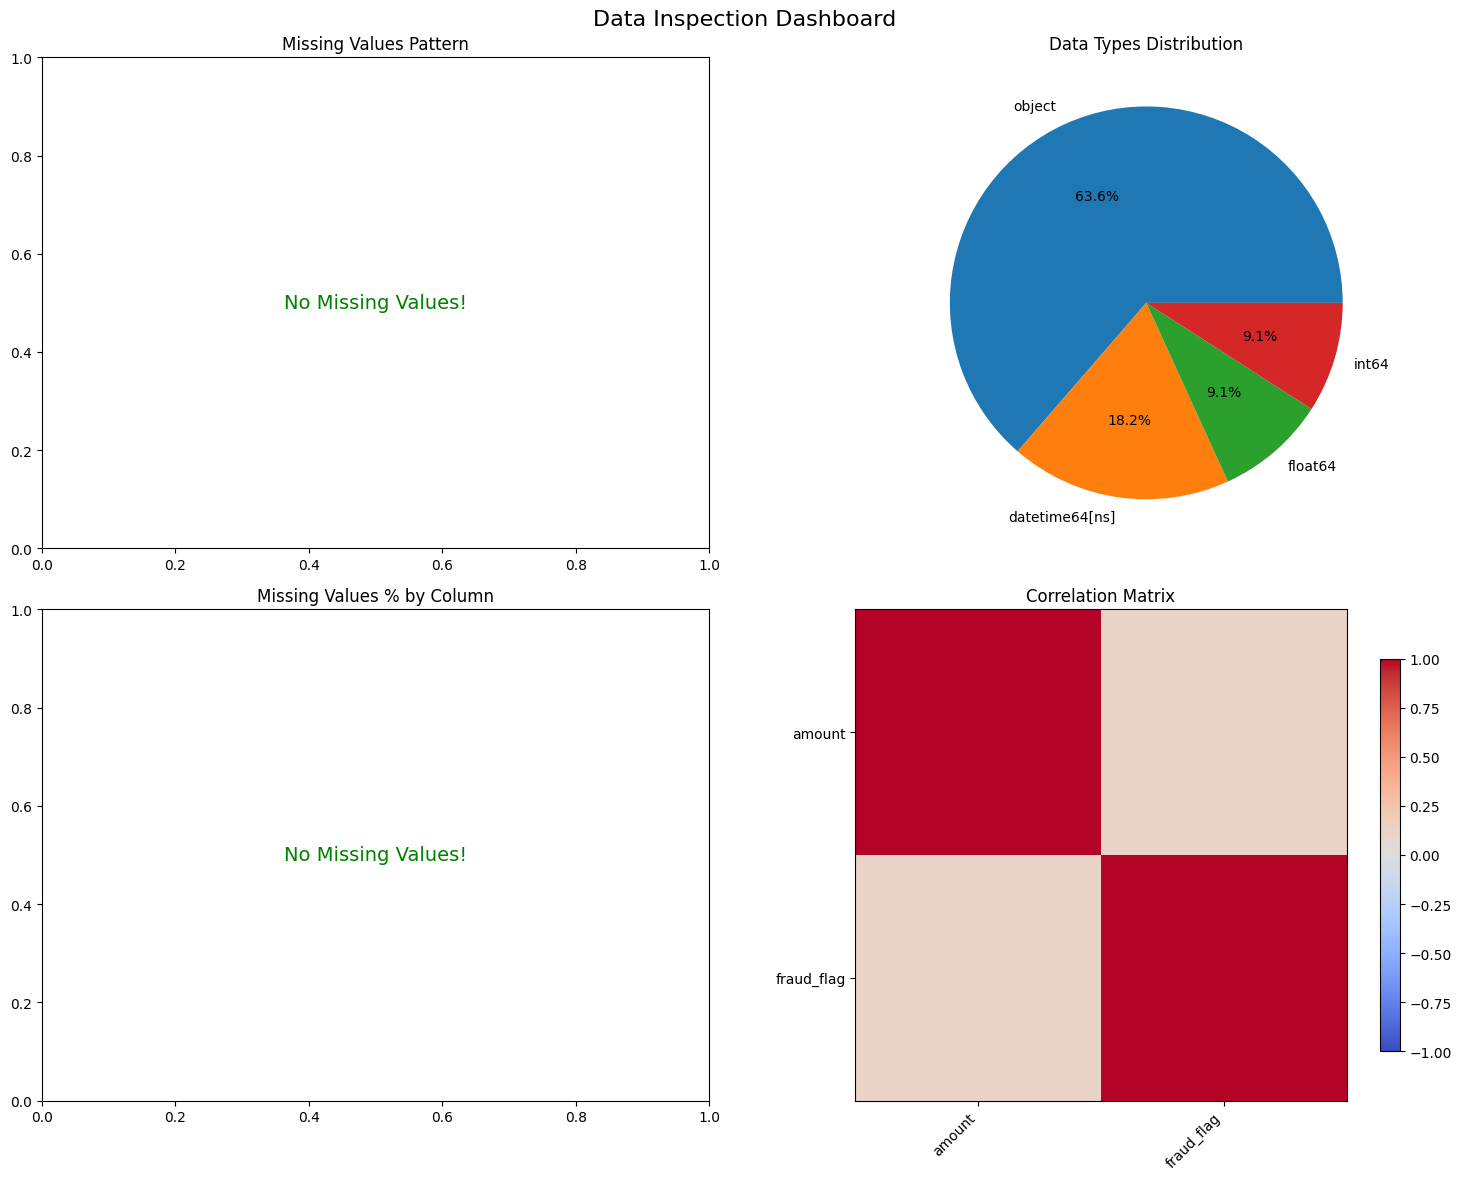

Report saved to inspection_report.txt


In [ ]:
# Create inspector
inspector = DataInspector(transactions_df, target_column='fraud_flag')

# Run complete inspection
results = inspector.inspect_all(show_plots=True)

# Generate report
#inspector.generate_report('inspection_report.txt')